<a href="https://colab.research.google.com/github/dariashcherbakovaaa/Algorithms-for-massive-data/blob/main/MBA_Shcherbakova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis on LinkedIn job skills and job links

###### **Daria Shcherbakova** *(DSE student, 17487A)*

## Environment settings & data loading

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName('Algo_Aprori').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark
import pyspark
type(spark)

sc = spark.sparkContext
spark

In [2]:
# os.environ['KAGGLE_USERNAME'] = "xxxxxx"
# os.environ['KAGGLE_KEY'] = "xxxxxx"

In [3]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f job_skills.csv
!unzip /content/job_skills.csv.zip -d job_skills

!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f linkedin_job_postings.csv
!unzip linkedin_job_postings.csv.zip -d linkedin_job_postings

os.remove('/content/job_skills.csv.zip')
os.remove('/content/linkedin_job_postings.csv.zip')

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 196M/197M [00:03<00:00, 59.1MB/s]
100% 197M/197M [00:03<00:00, 52.8MB/s]
Archive:  /content/job_skills.csv.zip
  inflating: job_skills/job_skills.csv  
Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 86% 81.0M/94.4M [00:01<00:00, 65.3MB/s]
100% 94.4M/94.4M [00:01<00:00, 75.5MB/s]
Archive:  linkedin_job_postings.csv.zip
  inflating: linkedin_job_postings/linkedin_job_postings.csv  


In [4]:
data_path = '/content/job_skills/job_skills.csv'
df_skills = spark.read.csv(data_path, inferSchema=True, header=True)
df_skills.printSchema()
df_skills.show()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
|https://www.linke...|Host/Server Assis...|
|https://www.linke...|Apartment mainten...|
|https://www.linke...|Fiber Optic Cable...|
|https://www.linke...|CT Technologist, ...|
|https://ca.linked...|SAP, DRMIS, Data ...|
|https://www.linke...|Debt and equity o...|
|https://ca.linked...|Biomedical Engine...|
|https://www.linke...|Laboratory

In [5]:
data_path = '/content/linkedin_job_postings/linkedin_job_postings.csv'
df_all = spark.read.csv(data_path, inferSchema=True, header=True)
df_all.printSchema()
df_all.show()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|    search_c

## Data pre-processing

#### Additional dataset to select actual job

In [6]:
df_all = df_all[['job_link', 'job_title', 'search_country', 'search_position', 'job_level']]
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [7]:
df_all.describe()

summary,job_link,job_title,search_country,search_position,job_level
count,1348488,1348488,1348420,1348420,1348420
mean,null,null,null,null,null
stddev,null,null,null,null,null
min,"New""","""""""A"""" Softball C...",2024-01-13,Able Seaman,Administrative As...
max,https://za.linked...,"🔥Nurse Manager, ...",United States,Zoo Veterinarian,United States


In [8]:
df_all = df_all.where((df_all['job_level'] == 'Mid senior') & (df_all['search_country'] == 'United States'))
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [9]:
df_all.groupBy('job_title')\
      .count()\
      .orderBy('count', ascending=False)\
      .show()

+--------------------+-----+
|           job_title|count|
+--------------------+-----+
|LEAD SALES ASSOCI...| 7305|
|       Shift Manager| 5727|
|First Year Tax Pr...| 5350|
|LEAD SALES ASSOCI...| 4888|
|   Assistant Manager| 4606|
|Customer Service ...| 4599|
|CUSTOMER SERVICE ...| 4195|
|       Store Manager| 3929|
|Hourly Supervisor...| 2941|
|Travel Allied Hea...| 2920|
|    Registered Nurse| 2783|
|                Host| 2779|
|Hourly Supervisor...| 2227|
|  Restaurant Manager| 2135|
|OPERATIONS ASSIST...| 2062|
|Assistant General...| 1952|
|        Veterinarian| 1947|
|   Senior Accountant| 1914|
|   Account Executive| 1824|
|Department Superv...| 1685|
+--------------------+-----+
only showing top 20 rows



In [10]:
import re

pattern_danalyst = r'\bdata\sanal\w*' # data analyst
pattern_banalyst = r'\bbusiness\sanal\w*' # business analyst
pattern_scientist = r'\bdata\sscientist\w*' # data scientist
pattern_engineer = r'\bdata\sengin\w*' #data engenineer

In [11]:
from pyspark.sql.functions import col, lower, regexp_extract

df_all_sampled = df_all.filter(
    (lower(col('job_title')).rlike(pattern_danalyst)) |
    (lower(col('job_title')).rlike(pattern_banalyst)) |
    (lower(col('job_title')).rlike(pattern_scientist)) |
    (lower(col('job_title')).rlike(pattern_engineer))
)
print((df_all_sampled.count(), len(df_all_sampled.columns)))

(7038, 5)


In [12]:
new_names = ['link', 'job_title', 'country', 'serach', 'level']

df_all_sampled = df_all_sampled.toDF(*new_names)
df_all_sampled.limit(5)\
              .toPandas() # i like pandas view more

,link,job_title,country,serach,level
0,https://www.linkedin.com/jobs/view/secret-clea...,Secret cleared Business Analyst,United States,Quality Assurance Analyst,Mid senior
1,https://www.linkedin.com/jobs/view/business-an...,Business Analyst (11076-1),United States,Consultant Education,Mid senior
2,https://www.linkedin.com/jobs/view/payment-swi...,Payment (Swift) (Business Analyst),United States,Instructor Business Education,Mid senior
3,https://www.linkedin.com/jobs/view/principal-b...,Principal Business Analyst,United States,Management Analyst,Mid senior
4,https://www.linkedin.com/jobs/view/lead-data-e...,Lead Data Engineer,United States,Maintenance Data Analyst,Mid senior


#### The main dataset with links and skills

In [13]:
new_names = ['link', 'skill']

df_skills = df_skills.toDF(*new_names)
df_skills.show(5)

+--------------------+--------------------+
|                link|               skill|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
+--------------------+--------------------+
only showing top 5 rows



In [14]:
df_skills.describe()

summary,link,skill
count,1296381,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


In [15]:
df_skills = df_skills.dropna() # drop empty, NA cells
df_skills = df_skills.dropDuplicates() # drop repeated cells

df_skills.describe()

summary,link,skill
count,1294374,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


#### data merging and sampling

In [16]:
df_skills.groupBy('skill') \
         .count() \
         .orderBy('count', ascending=False) \
         .show() # first attempt to check the most "frequent" set of skills in dataset

+--------------------+-----+
|               skill|count|
+--------------------+-----+
|Front Counter, Dr...|  169|
|Front Counter, Dr...|  112|
|Communication, Co...|   90|
|Retail experience...|   83|
|Leadership, Train...|   75|
|VolunteerMatch, L...|   70|
|                None|   50|
|Food Safety, Inte...|   47|
|Supervisory exper...|   41|
|Food Safety, Inte...|   40|
|             Nursing|   38|
|This context does...|   36|
|Restaurant Manage...|   35|
|Physician, Obstet...|   33|
|Retail experience...|   32|
|Customer service ...|   32|
|Communication ski...|   31|
|Leadership, Train...|   30|
|Restaurant Manage...|   29|
|Teamwork, Positiv...|   29|
+--------------------+-----+
only showing top 20 rows



In [17]:
data = df_all_sampled.join(df_skills,['link'],how='inner')
data.count()

6795

In [18]:
data = data[['link', 'skill']]
data.limit(5)\
    .toPandas()

,link,skill
0,https://www.linkedin.com/jobs/view/aflcmc-busi...,"Business Analyst, DoD financial management pro..."
1,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, SQL, Database management, Macro..."
2,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Business Process Review, Re..."
3,https://www.linkedin.com/jobs/view/business-an...,"Alteryx Analytics, SQL, Data Validation, Alter..."
4,https://www.linkedin.com/jobs/view/business-an...,"Data Analysis, Process Improvement, Technology..."


#### EDA

In [19]:
df_pd = data.toPandas()
df_pd.shape

(6795, 2)

In [20]:
skills = df_pd['skill'].str.split(', ').explode()
df = pd.DataFrame(skills, index=None)
df.shape

(180380, 1)

In [21]:
counting = df.value_counts().sort_values(ascending = 0)
counting

skill                     
SQL                           3023
Python                        2388
Communication                 1704
Data Analysis                 1703
Project Management            1230
                              ... 
Rate analysis                    1
Rate changes                     1
Rate design                      1
Rates and Forms Management       1
Éditions Documentaires           1
Name: count, Length: 41020, dtype: int64

<Axes: xlabel='skill'>

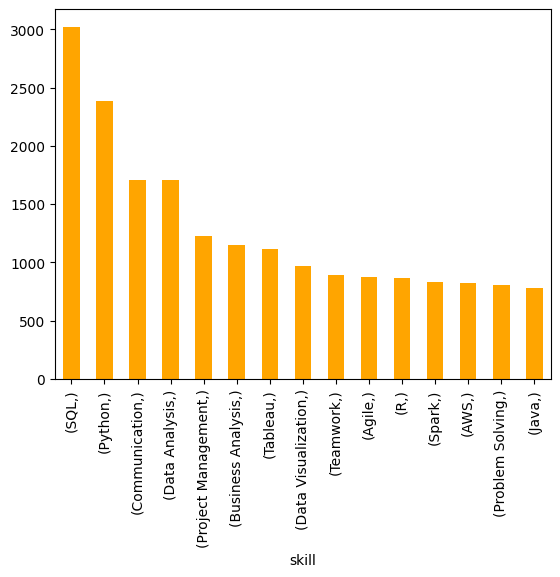

In [22]:
counting[:15].plot.bar(color = 'orange')

In [37]:
for index, row in df.iterrows():
    description = row['skill']
    try:
        lang = detect(description)
        if lang == 'en':
            job_desc = job_desc.append(row)
    except:
        continue

In [38]:
def clean_text(raw):

    try:
        # remove carriage returns and new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')

        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        raw = re.sub('null', '', raw)


        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)

        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text)

        # stripping first and last white space
        clean_text = clean_text.strip()

        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text)

        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')

        # using try and except due to Nan in the column
    except:
        clean_text = raw

    return clean_text

clean_text(df)

,skill
0,Business Analyst
0,DoD financial management processes
0,Government financial and accounting systems
0,Acquisition and budgeting processes
0,Relational databases
...,...
6794,Remote Work
6794,Pay Zones
6794,Salary Range
6794,Equity


In [42]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize

df['lower_skill'] = df.skill.str.lower()
tokenizer = RegexpTokenizer(r"\w+")
df['skill_tokenized'] = df.lower_skill.apply(lambda row: tokenizer.tokenize(row))
df['sentence_tokenized'] = df.skill.apply(lambda row: sent_tokenize(row))

df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,skill,lower_skill,skill_tokenized,sentence_tokenized
0,Business Analyst,business analyst,"[business, analyst]",[Business Analyst]
0,DoD financial management processes,dod financial management processes,"[dod, financial, management, processes]",[DoD financial management processes]
0,Government financial and accounting systems,government financial and accounting systems,"[government, financial, and, accounting, systems]",[Government financial and accounting systems]
0,Acquisition and budgeting processes,acquisition and budgeting processes,"[acquisition, and, budgeting, processes]",[Acquisition and budgeting processes]
0,Relational databases,relational databases,"[relational, databases]",[Relational databases]
...,...,...,...,...
6794,Remote Work,remote work,"[remote, work]",[Remote Work]
6794,Pay Zones,pay zones,"[pay, zones]",[Pay Zones]
6794,Salary Range,salary range,"[salary, range]",[Salary Range]
6794,Equity,equity,[equity],[Equity]


In [44]:
from nltk.corpus import stopwords

nltk.download('stopwords')
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    cleaned = [word for word in text if word not in stop_words]
    return cleaned

df['clean_stopword'] = df['sentence_tokenized'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
df.sample(12)

,skill,lower_skill,skill_tokenized,sentence_tokenized,clean_stopword
953,Pandas,pandas,[pandas],[Pandas],[Pandas]
1502,Test Concepts,test concepts,"[test, concepts]",[Test Concepts],[Test Concepts]
5901,STEM,stem,[stem],[STEM],[STEM]
6,SQL,sql,[sql],[SQL],[SQL]
5833,Computer Science,computer science,"[computer, science]",[Computer Science],[Computer Science]
920,Commerce Customer Experience,commerce customer experience,"[commerce, customer, experience]",[Commerce Customer Experience],[Commerce Customer Experience]
5760,PowerBI,powerbi,[powerbi],[PowerBI],[PowerBI]
6075,Computer Hardware,computer hardware,"[computer, hardware]",[Computer Hardware],[Computer Hardware]
2371,Business Intelligence,business intelligence,"[business, intelligence]",[Business Intelligence],[Business Intelligence]
1494,TradeDesk,tradedesk,[tradedesk],[TradeDesk],[TradeDesk]


## MBA I part: turning data into baskets

In [23]:
rdd = data.select(data.columns[1]).rdd
baskets = rdd.map(lambda x: x['skill']) \
             .map(lambda line: line.split(', '))
baskets.take(1)

[['Business Analyst',
  'DoD financial management processes',
  'Government financial and accounting systems',
  'Acquisition and budgeting processes',
  'Relational databases',
  'Financial and technical consulting',
  'Government finance expertise',
  'Financial data structuring',
  'Reconciliation between systems',
  'Financial forecasts and accounting data review',
  'Government financial office support',
  'Cost and Requirement System (CCaR™) experience',
  "Bachelor's degree in business management engineering computer science mathematics economics",
  '7+ years of government acquisition finance financial management program management or related experience',
  '10+ years of equivalent technical training or work/military experience',
  'Extended periods of sitting typing hearing seeing and speaking',
  'Prolonged computer work and typing',
  'Accurate communication',
  '15 lbs lifting/carrying',
  'Office mobility',
  'Federal background investigation',
  'Travel',
  'Varying work 

In [24]:
lenghts = baskets.map(lambda x: len(x))

print(f"Max number of items in the basket is: {lenghts.max()}\n",
      f"The average number of items in the basket is: {lenghts.mean()}\n",
      f"The total number of baskets is: {baskets.count()}\n",
      f"The approximate total number of items is:{round(lenghts.mean() * baskets.count())}", sep = '\n')

Max number of items in the basket is: 224

The average number of items in the basket is: 26.54598969830757

The total number of baskets is: 6795

The approximate total number of items is:180380


## MBA II part: apriori algorithm implementation

In [25]:
from itertools import combinations

In [26]:
def a_apriori(baskets, s, hash_table, k):
  """The first phase of algo: count occurencies of each item, select candidate item"""

  candidate_items = baskets.flatMap(lambda basket: [(item, 1) for item in basket]) \
                           .reduceByKey(lambda x1, x2: x1 + x2) \
                           .filter(lambda x: x[1] > s)


  top5 = candidate_items.takeOrdered(5, key=lambda x: -x[1])
  top_candidates_idx = [idx for idx, _ in top5]
  top_candidates = [list(hash_table.keys())[idx] for idx in top_candidates_idx]

  """The second phase of algo: create candidate pairs and check the frequency"""

  candidates = set(candidate_items.map(lambda x: (x[0],)).collect())

  candidate_itemsets = baskets.flatMap(lambda basket: [(itemset, 1) for itemset in combinations(sorted(basket), k)
                                                        if all(item in candidates for item in combinations(itemset, k-1))
                                                        ]) \
                              .reduceByKey(lambda x, y: x + y) \
                              .filter(lambda x: x[1] > s)

  top15 = candidate_itemsets.takeOrdered(15, key=lambda x: -x[1])
  top_pairs_idx = [pair for pair, _ in top15]
  top_idxs = [(idx1, idx2) for idx1, idx2 in top_pairs_idx]
  top_сandidate_itemsets = [(list(hash_table.keys())[idx1], list(hash_table.keys())[idx2]) for idx1, idx2 in top_idxs]


  return candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets

In [27]:
def supp(baskets, percentage):
  s = round(baskets.count() * percentage / 100)
  return s

support = supp(baskets, 1)
print(f"The support value is {support}")

The support value is 68


In [28]:
items = baskets.flatMap(lambda line: line) \
               .distinct()
items.take(5)

['Test cases',
 'Test data preparation',
 'Project status communication',
 'Airflow',
 'Mentoring']

In [29]:
items_index = items.zipWithIndex() \
                   .collectAsMap()

for elem, index in list(items_index.items())[:15]:
  print(f"{elem}: {index}")

print(f"\n\nThe total number of skills is {len(items_index)}")

Test cases: 0
Test data preparation: 1
Project status communication: 2
Airflow: 3
Mentoring: 4
Schema design: 5
PPC: 6
Supplier registration: 7
Stakeholder communication: 8
Computer skills: 9
Technical support: 10
Ability to work under pressure: 11
Cloud Technology: 12
Status Reporting: 13
Worldclass technology talent provision: 14


The total number of skills is 41020


In [30]:
def hashing(basket):
    return {items_index[skill] for skill in basket}

hashed_baskets = baskets.map(hashing)
hashed_baskets.take(1)

[{406,
  2240,
  2456,
  4099,
  6756,
  7168,
  7376,
  7764,
  9033,
  13664,
  13873,
  16413,
  16414,
  16614,
  19043,
  19693,
  20314,
  20923,
  22561,
  23187,
  23816,
  28149,
  29175,
  31035,
  32075,
  32937,
  32938,
  33317,
  36753,
  37372,
  38453,
  39282}]

In [31]:
candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets = a_apriori(hashed_baskets, support, items_index, 2)
print(f"The total number of frequent skills: {candidate_items.count()} ---> our candidate items")
print(f"Top-5 frequent skills: {', '.join(top_candidates)}")
print(f"The total number of frequent skills pairs: {candidate_itemsets.count()}")
print(f"Top-15 frequent skills pairs:")
for idx, (skill1, skill2) in enumerate(top_сandidate_itemsets):
  print(f"{idx+1}. {skill1} - {skill2}")

The total number of frequent skills: 352 ---> our candidate items
Top-5 frequent skills: SQL, Python, Communication, Data Analysis, Project Management
The total number of frequent skills pairs: 1657
Top-15 frequent skills pairs:
1. Python - SQL
2. SQL - Data Analysis
3. SQL - Tableau
4. Python - R
5. Python - Spark
6. Communication - SQL
7. Python - AWS
8. R - SQL
9. Python - Java
10. Python - Tableau
11. Data Visualization - SQL
12. Python - Machine Learning
13. Communication - Data Analysis
14. Python - Hadoop
15. Python - Scala
